In [67]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
from scipy.integrate import odeint
class ip:
    #Ip for 'inverse problem'
    # Initialize prior chain starting point,
    # chain burn-in length and total length, and 
    # Q (for proposal samples).  
    # Initialize experimental data.
    theta = np.array([0.15,5.])
    # theta is initialized as the starting point
    # of the chain.  It is placed at the prior
    # mean.
    mcmc_length = 100000
    mcmc_burn_in = 20000
    # trimmed off the beginning of the Markov
    # chain
    mu_prior = np.array([0.12,0.02,0.42])
    cov_prior = np.array([[0.05,0,0],
                          [0,0.5,0],
                          [0,0,1]]) 
    experiment = np.array([1,1,1])
    Q_mu = np.array([0,0,0]) # Q samples the next step at any point
    # in the chain.  The next step may be accepted or rejected.  Q_mu
    # is centered (0) around the current theta.
    Q_cov = cov_prior/20 # Take small steps.
    
    #main function to get samples
    def MetropolisHastings(self):
        samples = np.zeros((self.mcmc_length,3))
        samples[0,:] = self.mu_prior #initialize the chain
        likelihoods = np.zeros((self.mcmc_length,3))
        post_probabilities = np.zeros((self.mcmc_length,3))
        for i in range(1,self.mcmc_length):
            #print(i)
            proposal_sample = samples[i-1,:] + \
                np.random.multivariate_normal( \
                self.Q_mu,self.Q_cov) #1x3
            prior_proposal = self.prior(proposal_sample) #1
            likelihood_proposal = self.likelihood(proposal_sample) #1x3
            prior_current_location = self.prior(samples[i-1,:]) #1
            likelihood_current_location = self.likelihood(samples[i-1,:]) #1x3
            accept_pro=np.zeros((samples.shape[1],1))
            for j in range(samples.shape[1]):
                accept_pro[j] = (likelihood_proposal[j]*prior_proposal)/ \
                    (likelihood_current_location[j]*prior_current_location) #1
                uni_rand = np.random.uniform()
                if uni_rand<accept_pro[j]:
                    samples[i,:] = proposal_sample
                    post_probabilities[i,j] = \
                             likelihood_proposal[j]*prior_proposal
                    likelihoods[i,j] = likelihood_proposal[j]
                else:
                    samples[i,:] = samples[i-1,:]
                    post_probabilities[i,j] = likelihood_current_location[j]* \
                             prior_current_location
                    likelihoods[i,j] = likelihood_current_location[j]
            ########################################
        samples = samples[self.mcmc_burn_in:]
        post_probabilities = post_probabilities[self.mcmc_burn_in:]
        likelihoods = likelihoods[self.mcmc_burn_in:]
        evidence=np.zeros((samples.shape[1],1))
        ell=np.zeros((samples.shape[1],1))
        info_gain=np.zeros((samples.shape[1],1))
        likelihoods = np.nan_to_num(likelihoods)
        for k in range(samples.shape[1]):
            evidence[k] = np.sum(post_probabilities[:,k])/len(post_probabilities[:,k])
            ell[k] = np.log(np.sum(likelihoods[:,k])/len(likelihoods[:,k]))
            info_gain[k] = -(np.log(evidence[k])-ell[k])
        print('Likelihoods:',np.sum(likelihoods,axis=0))
        print('Length of likelihoods:',likelihoods.shape[0])
        print('Log likelihood:',ell) 
        return [evidence, info_gain, samples]
    
    #Function which returns derivatives
    def diffeq(self,C,t):
        k1=0.001
        k2=0.0015
        r1=k1*C[0]*C[0]
        r2=k2*C[1]
        dCadt = -r1
        dCbdt = r1 - r2
        dCcdt = r2
        return [dCadt,dCbdt,dCcdt]
    
    def prior(self,sample):
        probability = multivariate_normal.pdf(x=sample,
                         mean=self.mu_prior, 
                         cov=self.cov_prior)
        #print('prior: ' + str(probability))
        return probability
        
    def likelihood(self,sample):
        
        t = np.linspace(0,3600) #Time interval: 60 min
        conc_sol = odeint(self.diffeq,[sample[0],sample[1],sample[2]],t) #Solve the differential equation
        conc_sol_60=conc_sol[-1,:].T
        probability_a = multivariate_normal.pdf(x=conc_sol_60[0], \
                mean=self.experiment, cov=1)
        probability_b = multivariate_normal.pdf(x=conc_sol_60[1], \
                mean=self.experiment, cov=1)
        probability_c = multivariate_normal.pdf(x=conc_sol_60[2], \
                mean=self.experiment, cov=1)
                                              
        #probability = multivariate_normal.pdf(x=sample[0], \
        #        mean=self.experiment, cov=1) # Here we are putting
        #in the model and experiment
        #print('sample goose 0: ' + str(sample[0]))
        #print('experiment: ' + str(self.experiment))
        #print('likelihood: ' + str(probability))
        
        return [probability_a,probability_b,probability_c]



In [68]:
ip_object = ip()
ip_object.experiment = 0
[evidence, info_gain, samples] = ip_object.MetropolisHastings()
print('evidence: ' + str(evidence))
print('info_gain: ' + str(info_gain))


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars


Likelihoods: [30639.21843694 31482.12077508 24751.48671723]
Length of likelihoods: 80000
Log likelihood: [[-0.9597458 ]
 [-0.93260684]
 [-1.17314108]]
evidence: [[0.06546121]
 [0.06630593]
 [0.05447416]]
info_gain: [[1.76655174]
 [1.78086916]
 [1.73688776]]


In [3]:
# parameter 0 experiment=0
evidence_vec = np.zeros(4)
info_gain_vec = np.zeros(4)
evidence_vec[0] = 0.024756862216129997
info_gain_vec[0] = 2.5006261145102098
# parameter 0 experiment=1
evidence_vec[1] = 0.0313833286138141
info_gain_vec[1] = 2.3343657043673876
# parameter 0 experiment=2
evidence_vec[2] = 0.025070858390245445
info_gain_vec[2] = 2.491526671816456
# parameter 0 experiment=3
evidence_vec[3] = 0.011771329210355546
info_gain_vec[3] = 2.9996425239124913

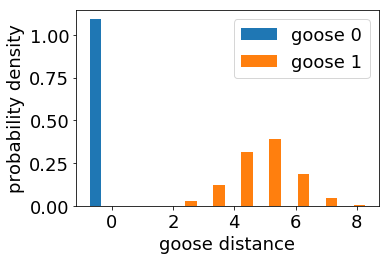

In [4]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.hist(samples,density=True)
ax.set_ylabel('probability density')
ax.set_xlabel('goose distance')
ax.legend(('goose 0','goose 1'))
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(left=0.2)
fig.savefig('assigment5_fig1.png', dpi=220)

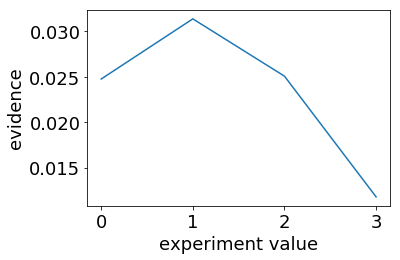

In [7]:
fig, ax = plt.subplots()
ax.plot(np.array([0,1,2,3]),evidence_vec)
ax.set_ylabel('evidence')
ax.set_xlabel('experiment value')
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(left=0.2)
fig.savefig('assigment5_fig2.png', dpi=220)


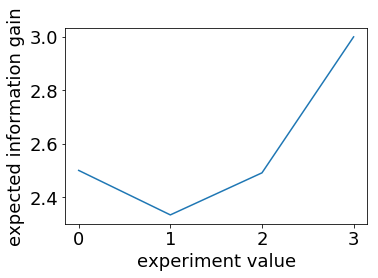

In [8]:
fig, ax = plt.subplots()
ax.plot(np.array([0,1,2,3]),info_gain_vec)
ax.set_ylabel('expected information gain')
ax.set_xlabel('experiment value')
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(left=0.2)
fig.savefig('assigment5_fig3.png', dpi=220)
